# Mapper

In this notebook, we will explore the Mapper algorithm for graph-based dimension reduction and data visualization. A nice implementation of the Mapper algorithm is built into the `giotto-tda` library. The first part of the notebook is adapted from a tutorial on the `giotto` [Github](https://github.com/giotto-ai/giotto-tda). As was mentioned last week, they have several other nice notebooks describing applications of TDA.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gtda.plotting import plot_point_cloud

from gtda.mapper import (
    CubicalCover,
    OneDimensionalCover,
    FirstSimpleGap,
    Eccentricity,
    Entropy,
    FirstHistogramGap,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)

from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

## Toy Data

We'll start with a basic example which will allow us to easily interpret the results of the mapper algorithm.

In [2]:
data, _ = datasets.make_circles(n_samples=5000, noise=0.05, factor=0.3, random_state=42)

plot_point_cloud(data)

## The Mapper Algorithm

Recall that a Mapper visualization of a finite metric space $(X,d_X)$ (such as a point cloud in $\mathbb{R}^n$) requires several parameters:

- A reference topological space $Y$ --- typically $\mathbb{R}$

- A function $f:X \to Y$ --- e.g., a data-driven function, a density estimate, eccentricity, etc.

- An open cover of $Y$ --- we'll generally pick from a built-in family of covers of $\mathbb{R}$

- A clustering algorithm --- our definition in class always used clusters coming from a Vietoris-Rips complex at a chosen scale $\epsilon > 0$; as was mentioned in class, we can choose from other clustering algorithms as well.

For each set $V_i$ in the open cover of $Y$, we pull back to an open set $U_i = f^{-1}(V_i)$ in $Y$. The open set is divided into clusters $U_i^{(1)},\ldots,U_i^{(n_i)}$ via the clustering algorithm. The Mapper graph is the 1-skeleton of the *nerve* of the collection $\{U_i^{(j)}\}$.

Let's choose various parameters now.

#### Filter Function

We can choos any `scikit-learn` [transformer](https://scikit-learn.org/stable/data_transforms.html). There are also some functions built into `giotto-tda`---see the [documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/mapper.html). 

Here we are using a function $f:X \to \mathbb{R}$ which projects onto the second coordinate. 

In [3]:
filter_func = Projection(columns=[1])

#### Cover

We'll choose from a built-in family of covers. Here we are just choosing a number of intervals and how much they overlap (similar to the picture we drew in lecture).

In [4]:
cover = OneDimensionalCover(n_intervals=10, overlap_frac=0.3)

#### Clustering

The default clustering algorithm is called `DBSCAN`.

In [5]:
clusterer = DBSCAN()

#### Mapper Pipeline

Now we create a Mapper pipeline which takes in all of these parameters. There is also an `n_jobs` parameter, in case we wanted to run some things in parallel.

In [6]:
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=1,
)

## Visualise the Mapper graph

Here is a plot of the resulting mapper graph with default options.

In [7]:
fig = plot_static_mapper_graph(pipe, data)
fig.show(config={'scrollZoom': True})

Note that these choices of parameters aren't capturing the correct topology. The Mapper graph *is* observing the two holes in the data, but it's not seeing the two connected components. Let's play around with parameters to see if we can get a Mapper graph that looks closer to the original data.

First we can change around the number of intervals and overlap fraction.

In [12]:
filter_func = Projection(columns=[1])
cover = OneDimensionalCover(n_intervals=50, overlap_frac=0.2)
clusterer = DBSCAN()

pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=1,
)

fig = plot_static_mapper_graph(pipe, data)
fig.show(config={'scrollZoom': True})

We can also change the clustering algorithm. Here we use the `FirstSimpleGap` function. This uses the Vietoris-Rips construction, but automatically chooses $\epsilon$ to be the height of the first 'significant gap' in the hierarchical clustering dendrogram.

In [13]:
filter_func = Projection(columns=[1])
cover = OneDimensionalCover(n_intervals=30, overlap_frac=0.2)
clusterer = FirstSimpleGap()

pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=1,
)

fig = plot_static_mapper_graph(pipe, data)
fig.show(config={'scrollZoom': True})

This seems to give a correct result!

We can also change the filter function to, say, $p$-eccentricity:
Let $(X,d_X)$ be a metric space. For $p\in\mathbb{Z}_{\geq 0}$, the $p$-eccentricity function $ e_p:X\to\mathbb{R}$ of $X$ is defined by sending $x\in X$ to $\sum_{x'\in X}d_X(x,x')^p/|X|$
 

This picks up connected components, but not cycles.

In [14]:
filter_func = Eccentricity(exponent = 1)
cover = OneDimensionalCover(n_intervals=30, overlap_frac=0.5)
clusterer = FirstSimpleGap()

pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=1,
)

fig = plot_static_mapper_graph(pipe, data)
fig.show(config={'scrollZoom': True})

Finally, we could change the target space $Y$ *and* the function $f:X \to Y$. We'll use $Y = \mathbb{R}^2$ and $f$ the identity function---this is not realistic for high-dimensional data, but we can use it for this low-dimensional example.

Since we are changing the target space, we also need to change the type of cover. We'll cover $Y$ by squares with a prescribed overlap percentage.

In [15]:
filter_func = Projection(columns=[0,1])
cover = CubicalCover(n_intervals=10, overlap_frac=0.2)
clusterer = DBSCAN()

pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=1,
)

fig = plot_static_mapper_graph(pipe, data)
fig.show(config={'scrollZoom': True})

This produces a very good result, which makes sense since we are using a filtration which faithfully represents the data.

## Creating custom filter functions

We can create custom filter functions. These will act row-wise on the input data.

In [16]:
filter_func = np.sum

pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=1,
)

In [17]:
fig = plot_static_mapper_graph(pipe, data)
fig.show(config={'scrollZoom': True})

## Interactive Visualization

A useful feature is live visualization, which can be used to tune parameters and see the result in real time.

In [18]:
pipe = make_mapper_pipeline()

# Generate interactive widget
plot_interactive_mapper_graph(pipe, data)

## Testing Mapper on Some Datasets

Next let's try to produce Mapper graphs for some real data. The `sklearn` package has several classic toy datasets that can be loaded. The available datasets can be found [here](https://scikit-learn.org/stable/datasets/toy_dataset.html).

We'll start with the `iris` dataset which contains measurements of flower biology coming from three classes of iris'.

The syntax for loading the data looks like this:

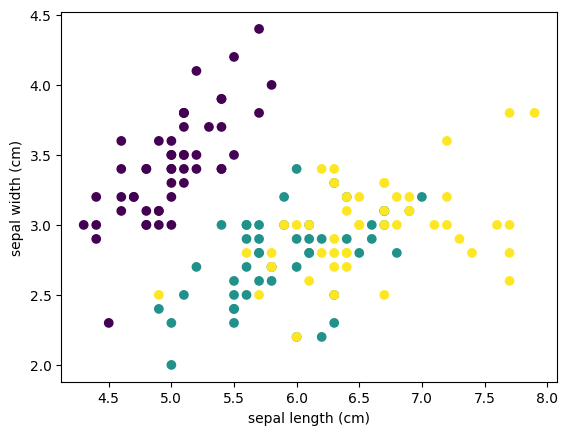

In [19]:
from sklearn.datasets import load_iris
iris = load_iris()
# Select the features to plot
x_index = 0
y_index = 1

# Create a scatter plot of the selected features
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])

plt.show()

This loads a dictionary, and we want to collect the data matrix and labels for analysis.

In [20]:
iris = load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [21]:
X = iris['data']
y = iris['target']

Looking at the shape of the data matrix, we see that there are 150 samples, with 4 features per sample.

In [22]:
X.shape

(150, 4)

There are 3 classes, indexed by the labels in `y`. The distribution of classes is even.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


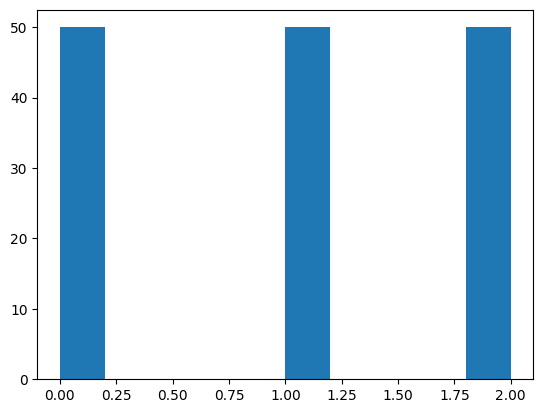

In [23]:
print(y)
plt.hist(y)
plt.show()

Let's take a look at the Mapper graph and play with parameters. Note that we can color the nodes by ground truth label, rather than function value.

In [24]:
filter_func = Projection(columns = [0])
clusterer = FirstSimpleGap()

pipe = make_mapper_pipeline(filter_func = filter_func, clusterer = clusterer)
plot_interactive_mapper_graph(pipe, X, color_data = y)

We can plot 2D projections of the data. We see that (for certain choices of parameters), the mapper graph does seem to reflect the shape of the data.

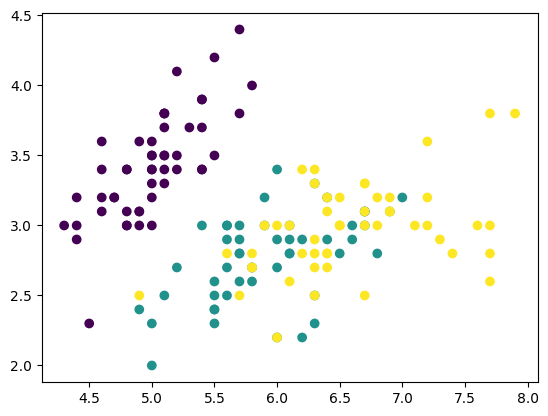

In [33]:
proj_coord1 = 0
proj_coord2 = 1

plt.scatter(X[:,proj_coord1],X[:,proj_coord2],c = y)